In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv('../data/kickstarter.csv')

In [49]:
def items_in_category(df, category, state, is_main_category):
    if is_main_category:
        temp = df[(df.main_category == category) & (df.state == state)]['state'].value_counts()
    else:
        temp = df[(df.category == category) & (df.state == state)]['state'].value_counts()
    return temp.at[state]

def goal_sum(df, category, is_main_category):
    if is_main_category:
        return df[df.main_category == category]["usd_goal_real"].sum()
    else:
        return df[df.category == category]["usd_goal_real"].sum()

In [50]:
main_categories = data["main_category"].values
main_categories = np.unique(main_categories)
main_categories = pd.Series(data=main_categories)

games = ["Tabletop Games", "Video Games"]
games = pd.Series(data=games)

categories = pd.concat([main_categories, games], ignore_index=True)

In [51]:
df_minus_video_tabletop = data[(data.category != "Tabletop Games") & (data.category != "Video Games")]

categories_df = pd.DataFrame(columns=['attained_goal', 'undershot_goal', 'canceled', 'goal_sum'])
categories_df.insert(loc=0, column='main_category', value=main_categories)

games_df = pd.DataFrame(columns=['attained_goal', 'undershot_goal', 'canceled', 'goal_sum'])
games_df.insert(loc=0, column='main_category', value=games)

# Fill 'attained_goal', 'undershot_goal', 'canceled' and 'goal_sum' columns
for main_category in main_categories:
    categories_df.loc[categories_df['main_category'] == main_category, 'attained_goal'] = items_in_category(df_minus_video_tabletop, main_category, 'successful', True)
    categories_df.loc[categories_df['main_category'] == main_category, 'undershot_goal'] = items_in_category(df_minus_video_tabletop, main_category, 'failed', True)
    categories_df.loc[categories_df['main_category'] == main_category, 'canceled'] = items_in_category(df_minus_video_tabletop, main_category, 'canceled', True)
    categories_df.loc[categories_df['main_category'] == main_category, 'goal_sum'] = goal_sum(df_minus_video_tabletop, main_category, True)

for game in games:
    games_df.loc[games_df['main_category'] == game, 'attained_goal'] = items_in_category(data, game, 'successful', False)
    games_df.loc[games_df['main_category'] == game, 'undershot_goal'] = items_in_category(data, game, 'failed', False)
    games_df.loc[games_df['main_category'] == game, 'canceled'] = items_in_category(data, game, 'canceled', False)
    games_df.loc[games_df['main_category'] == game, 'goal_sum'] = goal_sum(data, game, False)

categories_df = categories_df.append(games_df, ignore_index=True)

# Create new column for total number of projects
categories_df['total_projects'] = categories_df.apply(lambda row: row.attained_goal + row.undershot_goal + row.canceled, 
                                                      axis=1)

# Create new column for success ratio
categories_df['success_ratio'] = categories_df.apply(lambda row: (row.attained_goal) / (row.undershot_goal + row.canceled), 
                                                     axis=1)

# Create new column for average goal
categories_df['average_goal'] = categories_df.apply(lambda row: row.goal_sum / row.total_projects, 
                                                     axis=1)

# Sort by success ratio
categories_df = categories_df.sort_values('success_ratio', ascending=False)

# Change "Games" label for "Other Games"
categories_df.loc[8, 'main_category'] = "Other Games"
categories_df

,main_category,attained_goal,undershot_goal,canceled,goal_sum,total_projects,success_ratio,average_goal
3,Dance,2338,1235,163,3.61288e+07,3736,1.672389,9670.455559
14,Theater,6534,3708,608,2.95615e+08,10850,1.513902,27245.608301
15,Tabletop Games,7866,3878,2294,2.08381e+08,14038,1.274465,14844.034872
1,Comics,5842,4036,842,2.11743e+08,10720,1.197622,19752.174292
10,Music,24197,21752,3305,7.98092e+08,49254,0.965678,16203.595619
0,Art,11510,14131,2222,1.10356e+09,27863,0.703846,39606.557324
6,Film & Video,23623,32904,5755,5.25373e+09,62282,0.611061,84353.893708
4,Design,10550,14814,4152,1.25907e+09,29516,0.556259,42657.292822
12,Publishing,12300,23145,3602,9.88805e+08,39047,0.459865,25323.457164
11,Photography,3305,6384,986,1.32224e+08,10675,0.448440,12386.352059


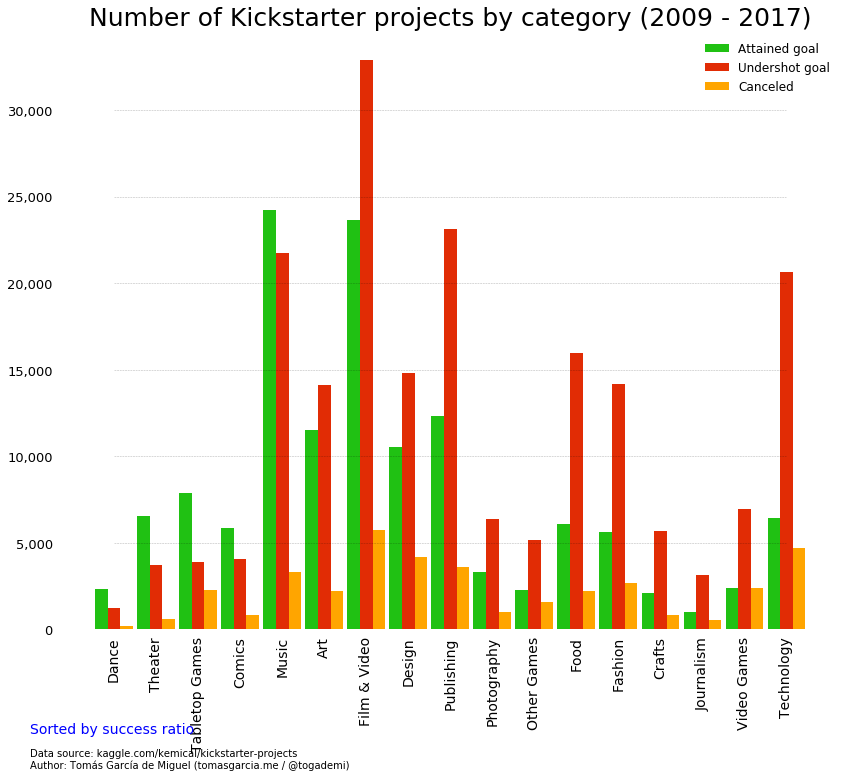

In [52]:
x = np.arange(categories.size)
fig, ax = plt.subplots()

width = 0.3
plt.xticks(x, categories_df.main_category, rotation='vertical', fontsize=14)

attained_goal = ax.bar(x - width, categories_df.attained_goal, width, color="#20C113")
undershot_goal = ax.bar(x, categories_df.undershot_goal, width, color="#E12C05")
canceled = ax.bar(x + width, categories_df.canceled, width, color="orange")

plt.title("Number of Kickstarter projects by category (2009 - 2017)", fontsize=25)
plt.yticks(fontsize=13)
plt.legend([attained_goal, undershot_goal, canceled], ["Attained goal", "Undershot goal", "Canceled"], 
           fontsize=12, frameon=False)

# Place a thousands separator in the labels of the y axis
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# Remove the plot frame lines
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)

# Provide tick lines across the plot
for y in range(5000, 35000, 5000):
    plt.plot(range(17), [y] * 17, "--", lw=0.5, color="black", alpha=0.3)

# Remove the tick marks    
plt.tick_params(axis="both", which="both", top=False, 
                left=False, bottom=False, right=False, labelleft=True)

# Change size of graph
fig.set_size_inches(14, 11)

plt.text(-2, -6000, "Sorted by success ratio", fontsize=14, color="blue")

plt.text(-2, -8000, "Data source: kaggle.com/kemical/kickstarter-projects"    
       "\nAuthor: Tomás García de Miguel (tomasgarcia.me / @togademi)", fontsize=10)

figure = plt.gcf()
plt.savefig('graph.png', dpi=300, bbox_inches="tight")
plt.show()

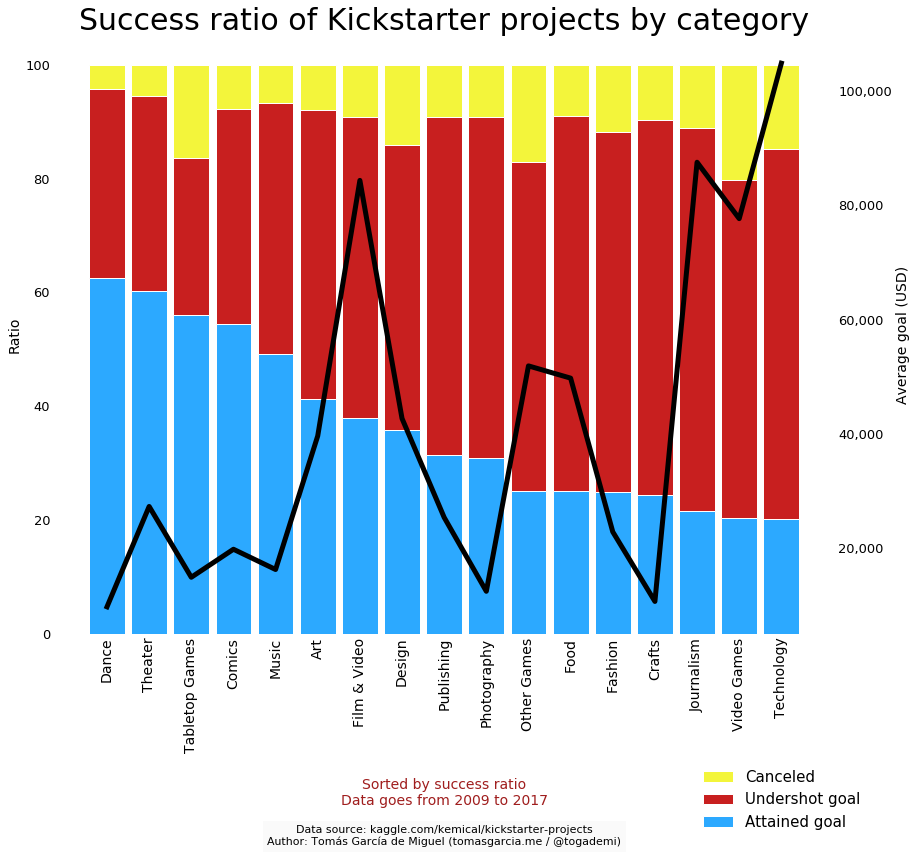

In [54]:
# Data

x = np.arange(categories.size)

width = 0.85

# From raw value to percentage
totals = [i+j+k for i,j,k in zip(categories_df['attained_goal'], categories_df['undershot_goal'], categories_df['canceled'])]
attained_goal = [i / j * 100 for i,j in zip(categories_df['attained_goal'], totals)]
undershot_goal = [i / j * 100 for i,j in zip(categories_df['undershot_goal'], totals)]
canceled = [i / j * 100 for i,j in zip(categories_df['canceled'], totals)]

# Plot bar graph

fig, ax = plt.subplots()

attained_goal_ax = ax.bar(x, attained_goal, width, color='#2CA9FF', edgecolor='white')
undershot_goal_ax = ax.bar(x, undershot_goal, width, bottom=attained_goal, color='#C81F1F', edgecolor='white')
canceled_ax = ax.bar(x, canceled, width, bottom=[i+j for i,j in zip(attained_goal, undershot_goal)], 
                     color='#F3F53B', edgecolor='white')

# Custom bar graph

# Remove the tick marks
plt.tick_params(axis="both", which="both", top=False, 
                left=False, bottom=False, right=False, labelleft=True)

plt.ylabel("Ratio", fontsize=14)
plt.xticks(x, categories_df.main_category, rotation='vertical', fontsize=14)
plt.title("Success ratio of Kickstarter projects by category", fontsize=30)
plt.yticks(fontsize=13)
plt.legend([canceled_ax, undershot_goal_ax, attained_goal_ax], ["Canceled", "Undershot goal", "Attained goal"], 
           fontsize=15, frameon=False, loc='lower right', bbox_to_anchor=(1.05, -0.35))
ax.tick_params(length=0)


# Remove the plot frame lines
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

# Change size of graph
fig.set_size_inches(14, 11)

plt.text(8, -30, "Sorted by success ratio"
         "\nData goes from 2009 to 2017", fontsize=14, color="#A01E1E", ha='center')

plt.text(8, -37, "Data source: kaggle.com/kemical/kickstarter-projects"
       "\nAuthor: Tomás García de Miguel (tomasgarcia.me / @togademi)", fontsize=11, ha='center', 
        backgroundcolor='#FAFAFA')

# Plot line graph

ax2 = ax.twinx()
average_goal = ax2.plot(x, categories_df["average_goal"], lw=5, color="black")
plt.ylabel("Average goal (USD)", fontsize=14)

# Custom line graph

# Place a thousands separator in the labels of the y axis
ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

plt.yticks(fontsize=13)
ax2.tick_params(length=0)

# Remove the plot frame lines
ax2.spines["top"].set_visible(False)
ax2.spines["bottom"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)

figure = plt.gcf()
plt.savefig('ks_success_ratio_avg_goal.png', dpi=300, bbox_inches="tight")
plt.show()